In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, datetime

# Einlesen der Datenreihen

Jupyter Notebooks

In [2]:
# Erzeugung durch Erneuerbare
# data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)['electricity']/1000
# data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)['electricity']/1000
# data_electrolysis = pd.read_excel('data/load_electrolysis.xlsx')['hydrogen']
# data_shipping_1 = pd.read_excel('data/Ferntransport.xlsx')['Kapazität [MWh]']
# data_shipping_2 = 0

Google Colab mit Drive Access

In [3]:
#infeed renewables
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)
data_electrolysis = pd.read_excel('data/load_electrolysis.xlsx')
data_shipping_1 = pd.read_excel('data/Ferntransport.xlsx')
data_shipping_2 = 0

In [4]:
dataset_df=pd.DataFrame()
dataset_df['Zeitstempel']=data_pv['time']
dataset_df['PV_Erzeugung']=data_pv['electricity']
dataset_df['Wind_Erzeugung']=data_wind['electricity']
dataset_df['Elektrolyse']=data_electrolysis['hydrogen']
dataset_df['Kapazität_Schiff']=data_shipping_1['Kapazität [MWh]']
dataset_df.Kapazität_Schiff=dataset_df.Kapazität_Schiff.fillna(method='ffill')
dataset_df.head(10000)

,Zeitstempel,PV_Erzeugung,Wind_Erzeugung,Elektrolyse,Kapazität_Schiff
0,2019-01-01 00:00,0.000,8.015,1,0.0
1,2019-01-01 01:00,0.000,0.524,1,0.0
2,2019-01-01 02:00,0.000,0.093,1,0.0
3,2019-01-01 03:00,0.000,0.050,1,0.0
4,2019-01-01 04:00,0.000,0.064,1,0.0
...,...,...,...,...,...
8755,2019-12-31 19:00,563.136,162.500,1,0.0
8756,2019-12-31 20:00,402.398,124.874,1,0.0
8757,2019-12-31 21:00,204.904,101.931,1,0.0
8758,2019-12-31 22:00,32.584,95.503,1,0.0


In [5]:
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)
data_electrolysis = pd.read_excel('data/load_electrolysis.xlsx')
data_shipping_1 = pd.read_excel('data/Ferntransport.xlsx')
data_shipping_2 = 0

In [6]:
# Inputs Variablen
data_inputs = pd.read_excel('data/Inputs_Modell.xlsx', sheet_name = 'Gesamt', header = 2, index_col = 0)

data_inputs=pd.DataFrame(data_inputs)
data_inputs.head()

,Unnamed: 1,name,bus,p_nom,marginal_cost,lifetime,capital_cost,efficiency,standing_loss,length,s_max_pu,Unnamed: 12
NaN,NaN,string,string,series,static,float,float,float,float,float,series,NaN
Photovoltaik (Chile),Generator,x,x,x,NaN,NaN,NaN,n.v.,n.v.,n.v.,n.v.,NaN
Windkraft (Chile),Generator,x,x,x,NaN,NaN,NaN,n.v.,n.v.,n.v.,n.v.,NaN
PEM Elektrolyse,Link,x,x,Simulation,95.226003,10,720000,0.598911,n.v.,n.v.,n.v.,[2]
AEL Elektrolyse,Link,x,x,Simulation,120.831319,10,630000,0.617978,n.v.,n.v.,n.v.,[2]


In [7]:
# Erstellung Last
hydrogen_energy_content = 33 #kWh/kg
hydrogen_demand_t = 35 * 1000
hydrogen_demand_kg = hydrogen_demand_t * 1000
hydrogen_demand_MWh = hydrogen_demand_t * hydrogen_energy_content # MWh
hydrogen_demand_hourly = hydrogen_demand_MWh/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' MWh')

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr 132.0 MWh


# Definition der Variablen

## Leistungen

In [8]:
p_nom_pv = dataset_df['PV_Erzeugung'].max()
p_nom_wind = dataset_df['Wind_Erzeugung'].max()

## Investitionskosten

In [9]:
# generators
capital_cost_pv = 0 # €/MW
capital_cost_wind = 0 # €/MW

# links
capital_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['capital_cost'] # €/MW
capital_cost_AEL = data_inputs.loc['AEL Elektrolyse']['capital_cost'] # €/MW
#capital_cost_HTEL = 1300 # €/MW
capital_cost_NH3 = 1400 # €/MW
capital_cost_LH2 = data_inputs.loc['Verflüssigung']['capital_cost'] # €/MW
capital_cost_LOHC = 1600 # €/MW
capital_cost_pipeline = 5000 # €/MW
capital_cost_shipping_1 = 10000 # €/MW
capital_cost_shipping_2 = 80000 # €/MW

# storages
capital_cost_storage_GH2 = 200 # €/MW
capital_cost_storage_NH3 = 20 # €/MW
capital_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['capital_cost'] # €/MW
capital_cost_storage_LOHC = 20 # €/MW

## Gestehungskosten

In [10]:
# generators
marginal_cost_pv = data_inputs.loc['Photovoltaik (Chile)']['marginal_cost'] # €/MWh
marginal_cost_wind = data_inputs.loc['Windkraft (Chile)']['marginal_cost'] # €/MWh

# conversion
marginal_cost_PEMEL = data_inputs.loc['PEM Elektrolyse']['marginal_cost'] # €/MWh
marginal_cost_AEL = data_inputs.loc['AEL Elektrolyse']['marginal_cost'] # €/MWh
#marginal_cost_HTEL = 100 # €/MWh
marginal_cost_NH3 = 100 # €/MWh
marginal_cost_LH2 = data_inputs.loc['Verflüssigung']['marginal_cost'] # €/MWh
marginal_cost_LOHC = 100 # €/MWh

# storage
marginal_cost_storage_GH2 = 20 # €/MWh
marginal_cost_storage_NH3 = 20 # €/MWh
marginal_cost_storage_LH2 = data_inputs.loc['LH2 Speicher']['marginal_cost'] # €/MWh
marginal_cost_storage_LOHC = 20 # €/MWh

# transportation
marginal_cost_pipeline = 200 # €/MWh
marginal_cost_shipping_GH2 = 10 # €/MWh
marginal_cost_shipping_NH3 = 10 # €/MWh
marginal_cost_shipping_LH2 = 10 # €/MWh
marginal_cost_shipping_LOHC = 10 # €/MWh

## Sonstiges

In [11]:
# efficiencies
efficiency_PEMEL = data_inputs.loc['PEM Elektrolyse']['efficiency']
efficiency_AEL = data_inputs.loc['AEL Elektrolyse']['efficiency']
#efficiency_HTEL = 1
efficiency_NH3 = 1
efficiency_LH2 = data_inputs.loc['Verflüssigung']['efficiency']
efficiency_LOHC = 1

# lifetimes
lifetime_PEMEL = data_inputs.loc['PEM Elektrolyse']['lifetime']
lifetime_AEL = 20
#lifetime_HTEL = 20

# standing losses
standing_loss_GH2 = 0.05
standing_loss_NH3 = 0.05
standing_loss_LH2 = data_inputs.loc['LH2 Speicher']['standing_loss']
standing_loss_LOHC = 0.05

# Netzwerk aufbauen

In [12]:
network = pypsa.Network()
network.set_snapshots(range(8760))

## Buses

In [13]:
network.add('Bus', name = 'electricity')
network.add('Bus', name = 'GH2')
network.add('Bus', name = 'LH2')
network.add('Bus', name = 'NH3')
#network.add('Bus', name = 'LOHC')
#network.add('Bus', name = 'hydrogen')

network.add('Bus', name = 'bremerhaven')
network.add('Bus', name = 'cologne')

## Loads

In [14]:
network.add('Load', name = 'hydrogen_demand', bus = 'cologne', p_set = hydrogen_demand_hourly)

## Generators

In [15]:
network.add('Generator', name = 'Photovoltaik', bus = 'electricity', 
            p_nom = p_nom_pv, p_max_pu = dataset_df['PV_Erzeugung']/p_nom_pv, p_min_pu = dataset_df['PV_Erzeugung']/p_nom_pv, 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

#network.add('Generator', name = 'pv', bus = 'electricity', 
#            p_nom = p_nom_pv, p_max_pu = data_pv/p_nom_pv, p_nom_extendable = True,
#            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

network.add('Generator', name = 'Windkraft', bus = 'electricity',
            p_nom = p_nom_wind, p_max_pu = dataset_df['Wind_Erzeugung']/p_nom_wind, p_min_pu = dataset_df['Wind_Erzeugung']/p_nom_wind, p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

## Links - Electrolysis

In [16]:
network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
            p_nom = p_nom_pv, p_max_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), p_min_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
            efficiency = efficiency_PEMEL)


In [17]:
network.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_AEL, capital_cost = capital_cost_AEL,
           efficiency = efficiency_AEL)


network.add('Link', name = 'HTEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_HTEL, capital_cost = capital_cost_HTEL,
           efficiency = efficiency_HTEL)

## Links - Conversion

In [18]:
network.add('Link', name = 'Verflüssigung', bus0 = 'GH2', bus1 = 'LH2',
            p_nom = p_nom_pv, p_max_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(), p_min_pu = dataset_df['Elektrolyse']/dataset_df['Elektrolyse'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
            efficiency = efficiency_LH2)

network.add('Link', name = 'NH3', bus0 = 'electricity', bus1 = 'NH3',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_NH3, capital_cost = capital_cost_NH3,
           efficiency = efficiency_NH3)

network.add('Link', name = 'LOHC', bus0 = 'electricity', bus1 = 'LOHC',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LOHC, capital_cost = capital_cost_LOHC,
           efficiency = efficiency_LOHC)

## Links - Ferntransport

In [19]:
# long distance shipment
network.add('Link', name = 'Verschiffung', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_max_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(), p_min_pu = dataset_df['Kapazität_Schiff']/dataset_df['Kapazität_Schiff'].max(),
            p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_GH2, capital_cost = capital_cost_shipping_1)

network.add('Link', name = 'Ferntransport_NH3', bus0 = 'NH3', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_NH3)

network.add('Link', name = 'Ferntransport_LH2', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LH2)

network.add('Link', name = 'Ferntransport_LHOC', bus0 = 'LHOC', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LHOC)


## Links - Pipeline

In [20]:
network.add('Link', name = 'Pipeline', bus0 = 'bremerhaven', bus1 = 'cologne', p_nom_extendable = True)

## Storages

In [21]:
network.add('Store', name = 'Stromspeicher', bus = 'electricity', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'Ammoniakspeicher', bus = 'NH3', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_NH3, marginal_cost = marginal_cost_storage_NH3)

network.add('Store', name = 'Flüssigspeicher', bus = 'LH2', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LH2, marginal_cost = marginal_cost_storage_LH2)

network.add('Store', name = 'LHOC-Speicher', bus = 'LHOC', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LOHC, marginal_cost = marginal_cost_storage_LOHC)

network.add('Store', name = 'Gasspeicher', bus = 'bremerhaven', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2, marginal_cost = marginal_cost_storage_GH2)

# Optimierung des Systems

In [22]:
network.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.29s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-z9gs66un.lp
Reading time = 0.71 seconds
obj: 306600 rows, 148933 columns, 602442 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 306600 rows, 148933 columns and 602442 nonzeros
Model fingerprint: 0x990237c3
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e+00, 3e+06]
  Bounds range     [3e+09, 3e+09]
  RHS range        [1e+02, 1e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 263554 rows and 131312 columns
Presolve time: 0.67s
Presolved: 43046 rows, 17621 columns, 132512 nonze

INFO:pypsa.linopf:Optimization successful. Objective value: -1.99e+09


('ok', 'optimal')

# Auswertung der Ergebnisse

In [23]:
def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):

  fig = plt.figure(figsize=(19,8))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

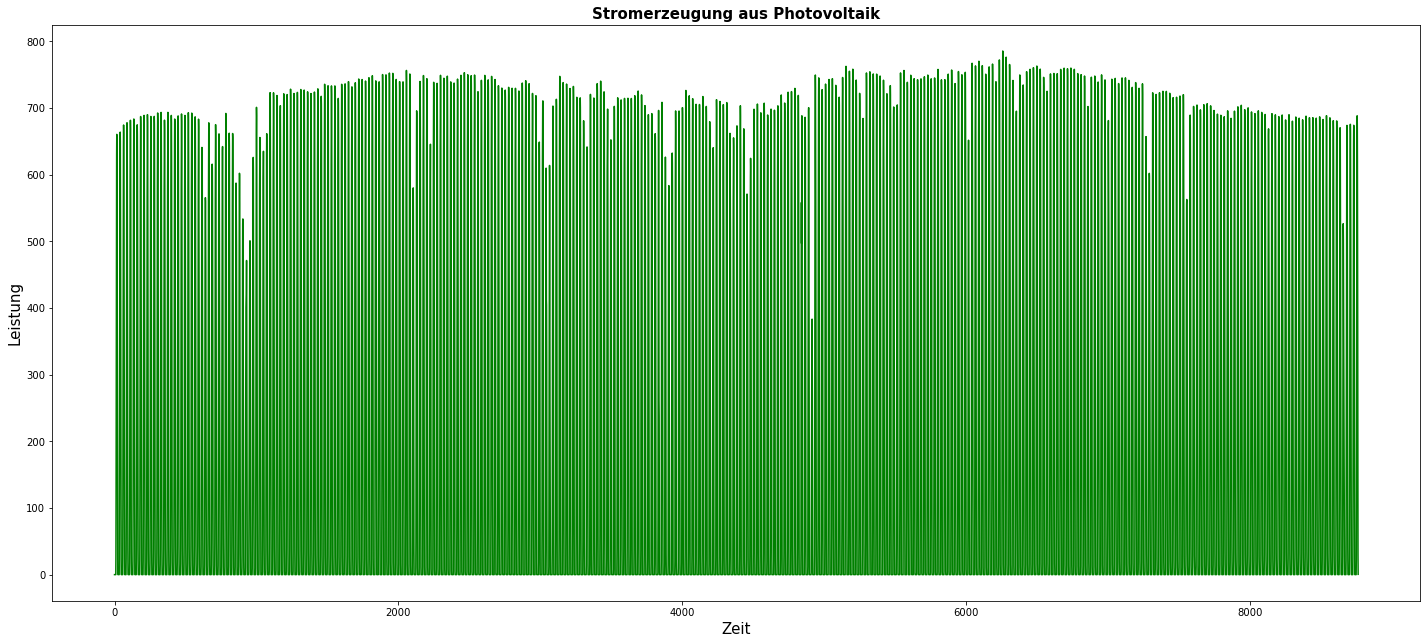

In [24]:
Jahresverlauf('Stromerzeugung aus Photovoltaik',dataset_df.index, network.generators_t.p['Photovoltaik'],'Zeit','Leistung')

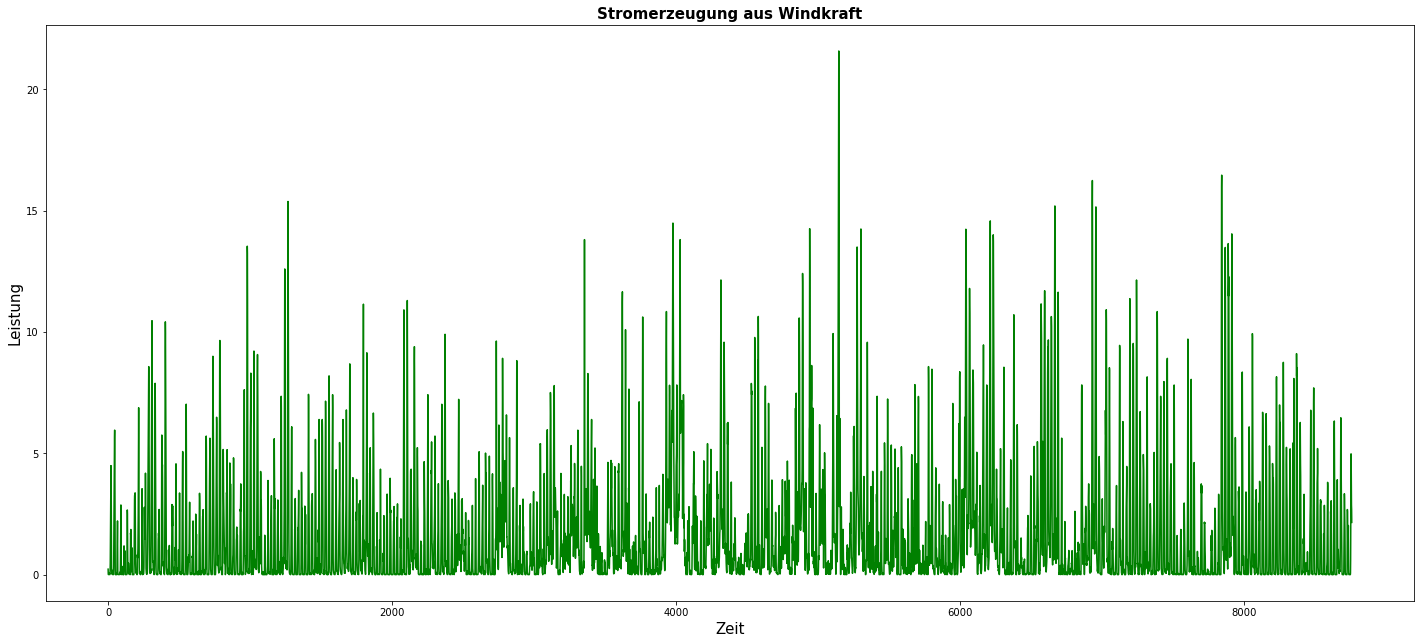

In [25]:
Jahresverlauf('Stromerzeugung aus Windkraft',dataset_df.index, network.generators_t.p['Windkraft'],'Zeit','Leistung')

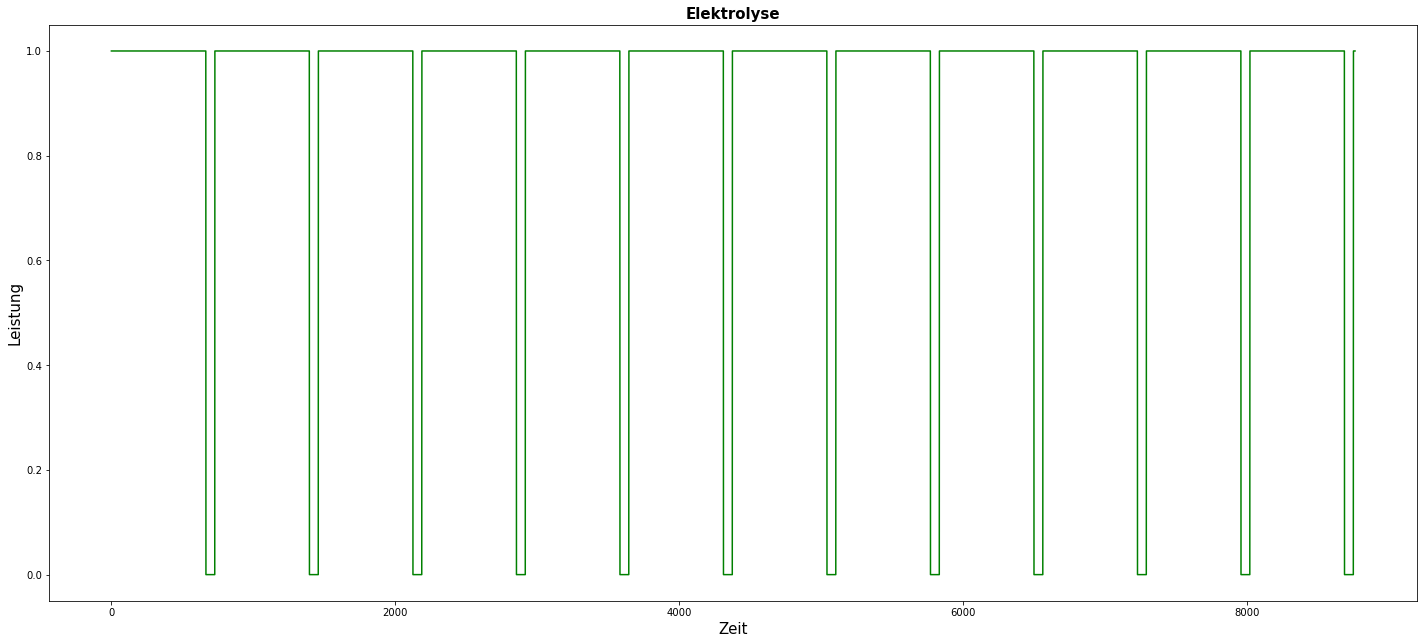

In [26]:
Jahresverlauf('Elektrolyse',dataset_df.index, dataset_df['Elektrolyse'],'Zeit','Leistung')

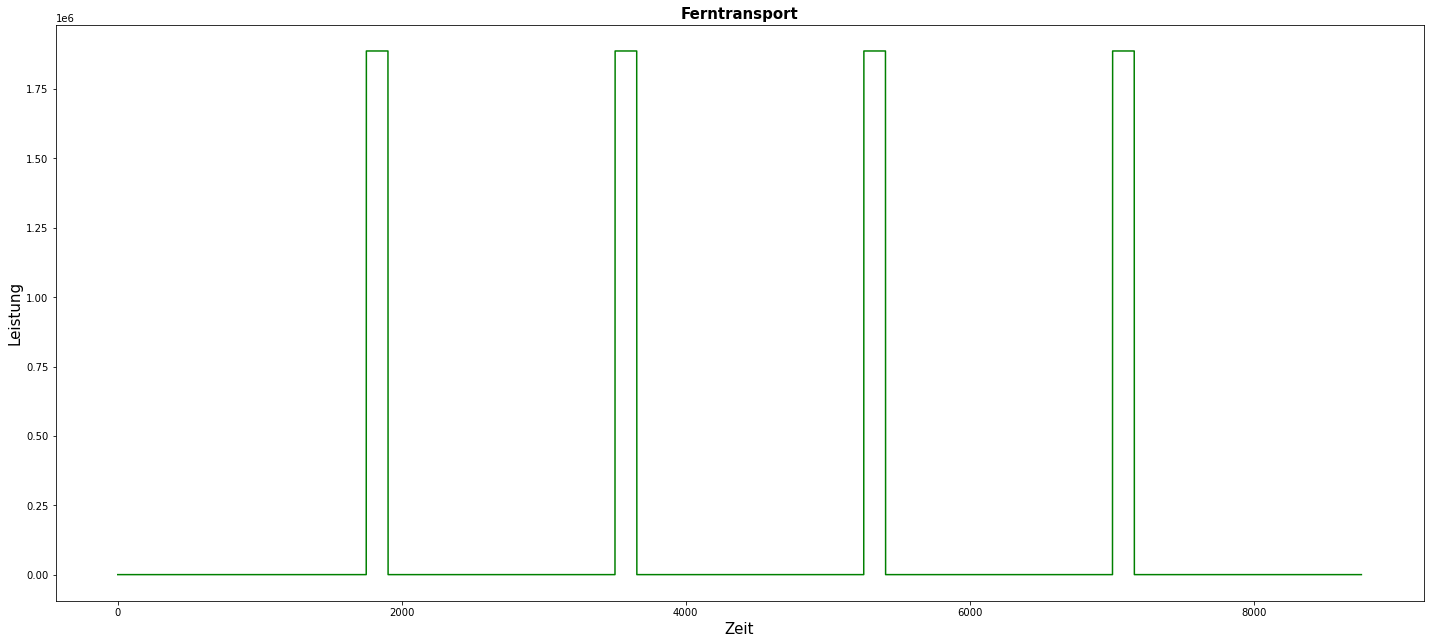

In [27]:
Jahresverlauf('Ferntransport',dataset_df.index, dataset_df['Kapazität_Schiff'],'Zeit','Leistung')

In [28]:
network.generators#.p_nom_opt

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Photovoltaik,electricity,Slack,,855.692,True,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,785.330701
Windkraft,electricity,PQ,,767.638,True,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,21.584898


<AxesSubplot:xlabel='snapshot', ylabel='Leistung in MW'>

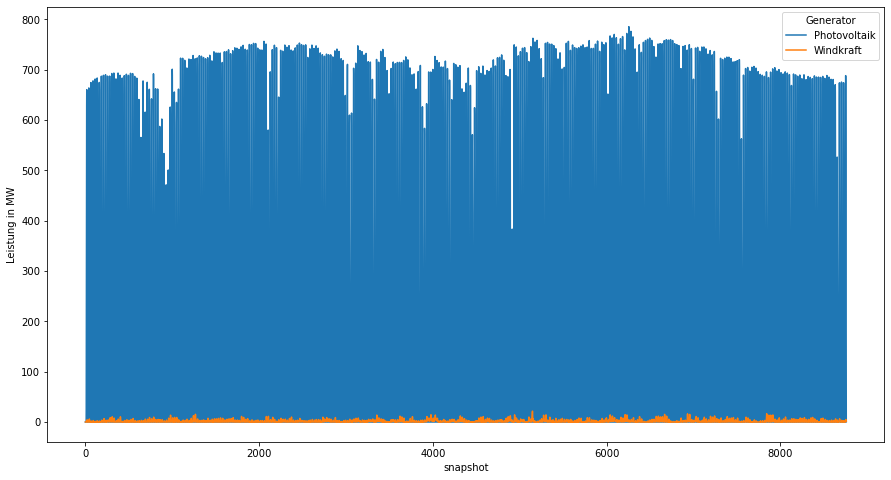

In [29]:
(network.generators_t.p).plot(figsize = (15,8), ylabel = 'Leistung in MW')

In [30]:
network.links#.p_nom_opt

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,ramp_limit_up,ramp_limit_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
PEMEL,electricity,GH2,,AC,0.598911,0,inf,855.692,True,0.0,...,0.0,0.0,1.0,7.200000e+05,95.226003,0.0,1.0,NaN,NaN,240.942057
AEL,electricity,GH2,,AC,0.617978,0,inf,0.000,True,0.0,...,0.0,0.0,1.0,6.300000e+05,120.831319,0.0,1.0,NaN,NaN,0.000000
Verflüssigung,GH2,LH2,,AC,1.000000,0,inf,855.692,True,0.0,...,0.0,0.0,1.0,3.296970e+06,6.060606,0.0,1.0,NaN,NaN,144.302849
Verschiffung,LH2,bremerhaven,,AC,1.000000,0,inf,0.000,True,0.0,...,0.0,0.0,1.0,1.000000e+04,10.000000,0.0,1.0,NaN,NaN,1887.254901
Pipeline,bremerhaven,cologne,,AC,1.000000,0,inf,0.000,True,0.0,...,0.0,0.0,1.0,0.000000e+00,0.000000,0.0,1.0,NaN,NaN,131.849315


<AxesSubplot:xlabel='snapshot', ylabel='Leistung in MW'>

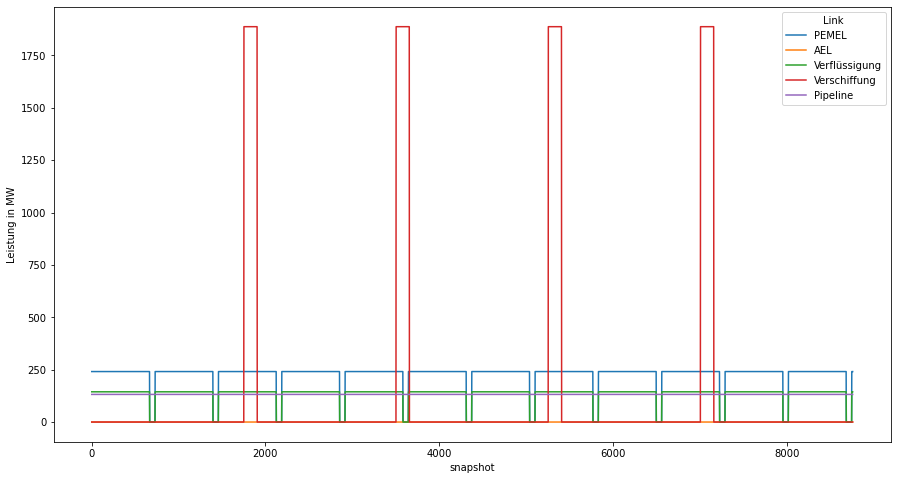

In [31]:
(network.links_t.p0).plot(figsize = (15,8), ylabel = 'Leistung in MW')

In [32]:
network.stores#.e_nom_opt

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,e_cyclic_per_period,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
Stromspeicher,electricity,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.000000,200.000000,0.0,0,inf,45750.000422
Ammoniakspeicher,NH3,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,20.000000,20.000000,0.0,0,inf,0.000000
Flüssigspeicher,LH2,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,21.818182,1090.909091,0.0,0,inf,438103.448048
LHOC-Speicher,LHOC,,NaN,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,20.000000,20.000000,0.0,0,inf,0.000000
Gasspeicher,bremerhaven,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,20.000000,200.000000,0.0,0,inf,441827.054565


<AxesSubplot:xlabel='snapshot'>

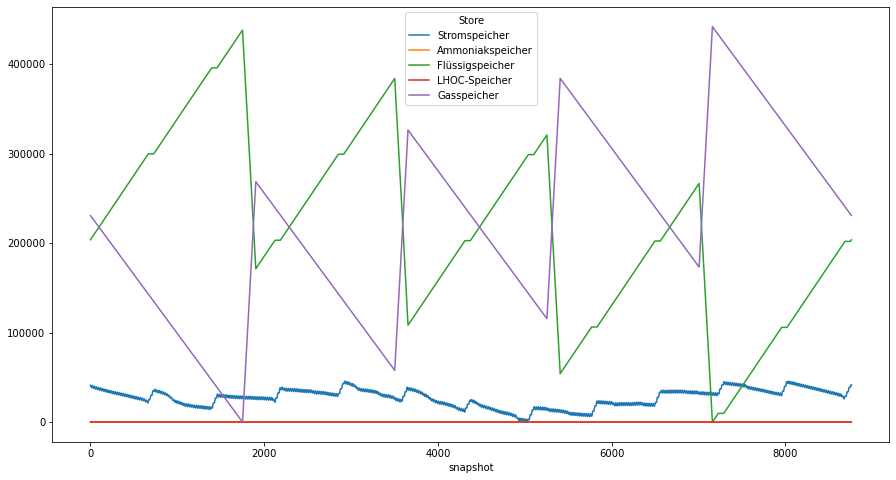

In [33]:
network.stores_t.e.plot(figsize = (15,8))

# Werkstatt

In [49]:
Elektrolysekosten = ((network.links.p_nom_opt * network.links.capital_cost)/network.links.lifetime+network.links.marginal_cost*hydrogen_demand_kg*(33/1000))/hydrogen_demand_kg
Elektrolysekosten

Link
PEMEL            3.142458
AEL              3.987434
Verflüssigung    0.200000
Verschiffung     0.330000
Pipeline         0.000000
dtype: float64

In [48]:
network.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,ramp_limit_up,ramp_limit_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
PEMEL,electricity,GH2,,AC,0.598911,0,inf,855.692,True,0.0,...,0.0,0.0,1.0,7.200000e+05,95.226003,0.0,1.0,NaN,NaN,240.942057
AEL,electricity,GH2,,AC,0.617978,0,inf,0.000,True,0.0,...,0.0,0.0,1.0,6.300000e+05,120.831319,0.0,1.0,NaN,NaN,0.000000
Verflüssigung,GH2,LH2,,AC,1.000000,0,inf,855.692,True,0.0,...,0.0,0.0,1.0,3.296970e+06,6.060606,0.0,1.0,NaN,NaN,144.302849
Verschiffung,LH2,bremerhaven,,AC,1.000000,0,inf,0.000,True,0.0,...,0.0,0.0,1.0,1.000000e+04,10.000000,0.0,1.0,NaN,NaN,1887.254901
Pipeline,bremerhaven,cologne,,AC,1.000000,0,inf,0.000,True,0.0,...,0.0,0.0,1.0,0.000000e+00,0.000000,0.0,1.0,NaN,NaN,131.849315


In [44]:
Speicherkosten = network.stores.e_nom_opt*network.stores.capital_cost
spez_Speicherkosten_MWh = Speicherkosten/hydrogen_demand_MWh
spez_Speicherkosten_kg = spez_Speicherkosten_MWh/hydrogen_energy_content
spez_Speicherkosten_kg

Store
Stromspeicher        0.240063
Ammoniakspeicher     0.000000
Flüssigspeicher     12.539185
LHOC-Speicher        0.000000
Gasspeicher          2.318389
dtype: float64

In [ ]:
labels = ['A', 'B']
Stromkosten = np.array([1.5,1.5])
Elektrolyse = np.array([0.5,1.5])
Speicherung = np.array([0.15,0.12])
Ferntransport_1 = np.array([1,0.2])
Inlandstransport = np.array([0.3,0.3])
Umwandlung = np.array([0.7,0.3])
Sonstige= np.array([0.1,0.3])
# the width of the bars: can also be len(x) sequence
width=0.5
fig, ax = plt.subplots(figsize=(7,10))
#x_pos = [-2,0,2]
ax.bar(labels, Stromkosten, label='Stromkosten',width=width,color='lightcoral')
ax.bar(labels, Elektrolyse, bottom=Stromkosten,
       label='Elektrolyse',width=width,color='indianred')
ax.bar(labels, Speicherung, bottom=Stromkosten+Elektrolyse,
       label='Speicherung',width=width,color='firebrick')
ax.bar(labels, Ferntransport_1, bottom=Stromkosten+Elektrolyse+Speicherung,
       label='Ferntransport',width=width,color='brown')
ax.bar(labels, Inlandstransport, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1,
       label='Inlandstransport',width=width,color='maroon')
ax.bar(labels, Umwandlung, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport,
       label='Umwandlung',width=width,color='darkred')
ax.bar(labels, Sonstige, bottom=Stromkosten+Elektrolyse+Speicherung+Ferntransport_1+Inlandstransport+Umwandlung,
       label='Sonstige',width=width,color='red')

ax.set_ylabel('Kosten in [€]')
ax.set_title('Wasserstoffbereitstellungskosten in €/kg Wasserstoff')
ax.legend(loc='upper right')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.02f}€'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            color='white',
            fontsize=14,
            )
  

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.xticks(x_pos, labels)
plt.show()